In [359]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from sklearn import set_config
set_config(transform_output='pandas')

%matplotlib inline
plt.style.use('seaborn-darkgrid')
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (10, 8)

# Загрузка данных

In [360]:
# %%capture
# !wget https://www.dropbox.com/s/64ol9q9ssggz6f1/data_ford_price.xlsx

In [361]:
data = pd.read_excel('data/data_ford_price.xlsx', engine='openpyxl')

# Предобработка: удаление пропусков

In [362]:
null_col = data.isnull().sum()
null_col

price              0
year               0
condition          0
cylinders          0
odometer           0
title_status       0
transmission       0
drive            391
size            1564
lat                0
long               0
weather          180
dtype: int64

Только столбцы в которых есть пропуски

In [363]:
null_col = list(null_col[null_col > 0].index)
null_col

['drive', 'size', 'weather']

Посмотрим, что будет, если просто убрать все строки с пропусками в столбце weather:

In [364]:
data[~data['weather'].isna()]

,price,year,condition,cylinders,odometer,title_status,transmission,drive,size,lat,long,weather
0,43900,2016,4,6,43500,clean,automatic,4wd,full-size,36.471500,-82.483400,59.0
1,15490,2009,2,8,98131,clean,automatic,4wd,full-size,40.468826,-74.281734,52.0
2,2495,2002,2,8,201803,clean,automatic,4wd,full-size,42.477134,-82.949564,45.0
3,1300,2000,1,8,170305,rebuilt,automatic,4wd,full-size,40.764373,-82.349503,49.0
5,6995,2003,3,8,167662,clean,automatic,4wd,full-size,45.518031,-122.578752,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7012,22500,2015,3,6,23500,clean,automatic,rwd,full-size,32.680700,-117.169800,59.0
7013,5975,2005,2,8,0,clean,automatic,rwd,full-size,38.213303,-85.785762,50.0
7014,9999,2006,3,8,161514,clean,automatic,NaN,full-size,37.609783,-120.995406,59.0
7015,10900,2011,2,8,164000,clean,automatic,4wd,full-size,43.140600,-93.385000,47.0


### Задание 4.2
Какая доля строк в датасете останется, если убрать пропуски в столбце size? Ответ округлите до двух знаков после точки-разделителя.

In [365]:
round(data[~data['size'].isna()].shape[0] / data.shape[0], 2)

0.78

In [366]:
TARGET = 'price'

In [367]:
X, y = data.drop(columns=TARGET), data[TARGET]

In [368]:
X = X.dropna()

Мы удалили некоторые строки из таблицы x. Соответственно, надо сделать то же самое в целевой переменной y.

Выберем все оставшиеся индексы таблицы x с помощью метода index(), а затем используем .iloc[], чтобы получить подгруппу целевых значений, соответствующую полученным индексам.

In [369]:
y = y.iloc[X.index]

Проще было сналача удалить строки, а потом уже делить датасет на X, y.

In [370]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

## Кодирование категориальных переменных

In [371]:
columns_to_change = ['cylinders', 'title_status', 'transmission', 'drive', 'size']

In [372]:
# from sklearn.preprocessing import OneHotEncoder

# def encode_cat_features(columns_to_change, X_train, X_test):
#   one_hot_encoder = OneHotEncoder()
#   # Кодирование переданного списка признаков
#   X_train_onehot = one_hot_encoder.fit_transform(X_train[columns_to_change]).toarray()
#   X_test_onehot = one_hot_encoder.transform(X_test[columns_to_change]).toarray()

#   # Имена признаков полученные после кодирования
#   columns = one_hot_encoder.get_feature_names_out()
  
#   X_train_onehot_df = pd.DataFrame(X_train_onehot, columns=columns)
#   X_test_onehot_df = pd.DataFrame(X_test_onehot, columns=columns)

#   # Сбрасываю индексы после удаление части записей с пропусками 
#   X_train = X_train.reset_index(drop=True)
#   X_test = X_test.reset_index(drop=True)

#   # Удаляю исходные признаки, по которым произвел кодировку
#   X_train.drop(columns=columns_to_change, inplace=True)
#   X_test.drop(columns=columns_to_change, inplace=True) 
  
#   # Объединяю в единые датафреймы
#   X_train_new = pd.concat([X_train, X_train_onehot_df], axis=1)
#   X_test_new = pd.concat([X_test, X_test_onehot_df], axis=1)

#   return X_train_new, X_test_new

# X_train_new, X_test_new = encode_cat_features(columns_to_change, X_train, X_test)

Намного проще использовать библиотеку category_encoders

In [373]:
from category_encoders import OneHotEncoder

ohe = OneHotEncoder(cols=columns_to_change, use_cat_names=True)
X_train_new = ohe.fit_transform(X_train)
X_test_new = ohe.transform(X_test)

## Обучение модели 

In [374]:
lr_model = LinearRegression()

In [375]:
lr_model.fit(X_train_new, y_train)

y_train_predict = lr_model.predict(X_train_new)
y_test_predict = lr_model.predict(X_test_new)

print("Train R^2: {:.3f}".format(r2_score(y_train, y_train_predict)))
print("Test R^2: {:.3f}".format(r2_score(y_test, y_test_predict)))

Train R^2: 0.647
Test R^2: 0.693


# Предобработка: заполнение пропусков

Теперь давайте попробуем заполнить пропуски константными значениями и обучить модель заново. 

Плюс такого подхода состоит в том, что мы предотвращаем потерю данных, которая происходит при удалении строк или столбцов. 

Основной минус — в снижении разброса (разнообразия) признаков.

In [376]:
X, y = data.drop(columns=TARGET), data[TARGET]

In [377]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [378]:
# Заполняем средним значением погоду
X_train['weather'] = X_train['weather'].fillna(np.round(np.mean(X_train['weather']), 0))
X_test['weather'] = X_test['weather'].fillna(np.round(np.mean(X_train['weather']), 0))

Заполняем модой drive, size

In [379]:
drive_mode_value = X_train['drive'].value_counts(True).head(1).index[0]
drive_mode_value

'4wd'

In [380]:
size_mode_value = X_train['size'].value_counts(True).head(1).index[0]
size_mode_value

'full-size'

In [381]:
X_train['size'] = X_train['size'].fillna(size_mode_value)
X_train['drive'] = X_train['drive'].fillna(drive_mode_value)
 
X_test['size'] = X_test['size'].fillna(size_mode_value)
X_test['drive'] = X_test['drive'].fillna(drive_mode_value)

In [382]:
# X_train_new, X_test_new = encode_cat_features(columns_to_change, X_train, X_test)

In [383]:
ohe = OneHotEncoder(cols=columns_to_change, use_cat_names=True)
X_train_new = ohe.fit_transform(X_train)
X_test_new = ohe.transform(X_test)

In [384]:
lr_model = LinearRegression()
lr_model.fit(X_train_new, y_train)

y_train_predict = lr_model.predict(X_train_new)
y_test_predict = lr_model.predict(X_test_new)

print("Train R^2: {:.3f}".format(r2_score(y_train, y_train_predict)))
print("Test R^2: {:.3f}".format(r2_score(y_test, y_test_predict)))

Train R^2: 0.649
Test R^2: 0.465


Напомним: модели с коэффициентом детерминации выше 0.8 можно признать достаточно хорошими. 

Равенство коэффициента детерминации 1 означает, что объясняемая переменная в точности описывается рассматриваемой моделью.

# Предсказание пропусков с помощью ML

Приведённые методы обработки отсутствующих значений не учитывают корреляционную связь признака, содержащего пропуски, с остальными. Признаки, не имеющие NaN, можно использовать для прогнозирования пропущенных значений. Строится модель регрессии или классификации в зависимости от характера (категорийного или непрерывного) признака, имеющего пропущенное значение.

In [385]:
data = X.copy()
test_data = data[data['weather'].isnull()] # Оставляю только записи с пропусками в погоде
data.dropna(inplace=True) # Из данных удаляю все пропуски
 
y_train = data['weather'] # Существующий признак погоды использую теперь как целевой признак

# Удаляю все признаки в которых были пропуски их не использую ни для обучения, ни для проверки
X_train = data.drop(['size','weather','drive'], axis=1)
X_test = test_data.drop(['size','weather','drive'], axis=1)

In [386]:
categorial_cols = ['cylinders', 'title_status', 'transmission']

In [387]:
ohe = OneHotEncoder(cols=categorial_cols, use_cat_names=True)
X_train_new = ohe.fit_transform(X_train)
X_test_new = ohe.transform(X_test)

In [388]:
# X_train_new, X_test_new = encode_cat_features(categorial_cols, X_train, X_test)

In [389]:
model = LinearRegression()
model.fit(X_train_new, y_train)
 
y_pred = model.predict(X_test_new)

## Решение Задания 4.5


Вставьте найденную замену на место пропусков в столбце weather. Используйте тот же метод для заполнения пропусков в size. Обратите внимание на тип модели, который нужен (классификация или регрессия) в зависимости от типа признака. 

In [390]:
%%time
# Список индексов где в исходных данных были пропуски
weather_null_index_list = list(test_data.index)

# Заполнение признака weather в заданных индексах массивом предсказаний
X.loc[weather_null_index_list, 'weather'] = y_pred

CPU times: total: 0 ns
Wall time: 1e+03 µs


Ниже вариант реализации в олдовом стиле и все это работает на порядок медленнее

Wall time: 2.87 s

Вместо

Wall time: 2.06 ms

У метода выше через loc

In [391]:
# for i, ni in enumerate(test_data.index[:len(X)]):
#     X['weather'].loc[ni] = y_pred[i]

In [392]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7017 entries, 0 to 7016
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          7017 non-null   int64  
 1   condition     7017 non-null   int64  
 2   cylinders     7017 non-null   int64  
 3   odometer      7017 non-null   int64  
 4   title_status  7017 non-null   object 
 5   transmission  7017 non-null   object 
 6   drive         6626 non-null   object 
 7   size          5453 non-null   object 
 8   lat           7017 non-null   float64
 9   long          7017 non-null   float64
 10  weather       7017 non-null   float64
dtypes: float64(3), int64(4), object(4)
memory usage: 603.1+ KB


In [393]:
# У предсказанных значений на месте пропусков была излишняя точность
# Округляю и делею приведение типов до int
X['weather'] = X['weather'].round(0).astype('int')

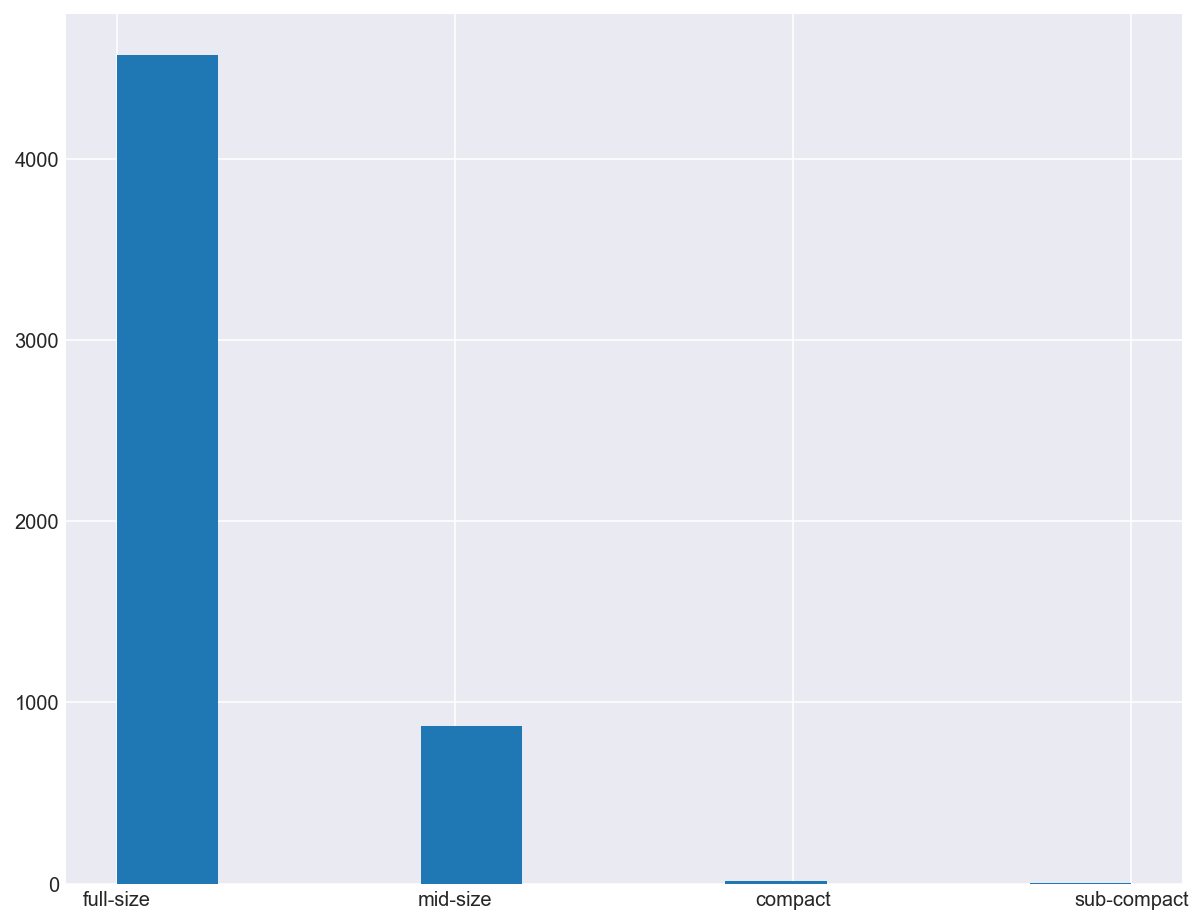

In [394]:
X['size'].hist();

Данный признак является категориальным. Следовательно, понадобится классификатор для заполения пропусков в нем.

In [395]:
data = X.copy()
test_data = data[data['size'].isnull()] # Оставляю только записи с пропусками в погоде
data.dropna(inplace=True) # Из данных удаляю все пропуски
 
y_train = data['size'] # Существующий признак использую теперь как целевой признак

# Удаляю все признаки в которых есть пропуски их не использую ни для обучения, ни для проверки
# Т.к. weather уже заполнен и не имеет пропусков, оставляю его
X_train = data.drop(['size', 'drive'], axis=1)
X_test = test_data.drop(['size','drive'], axis=1)

In [396]:
ohe = OneHotEncoder(cols=categorial_cols, use_cat_names=True)
X_train_new = ohe.fit_transform(X_train)
X_test_new = ohe.transform(X_test)

In [397]:
# X_train_new, X_test_new = encode_cat_features(categorial_cols, X_train, X_test)

In [398]:
model = LogisticRegression()
model.fit(X_train_new, y_train)

y_pred = model.predict(X_test_new)
y_pred

C:\Users\avvoy\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array(['full-size', 'full-size', 'full-size', ..., 'full-size',
       'full-size', 'full-size'], dtype=object)

In [399]:
%%time
# Список индексов где в исходных данных были пропуски
size_null_index_list = list(test_data.index)

# Заполнение признака size в заданных индексах массивом предсказаний
X.loc[size_null_index_list, 'size'] = y_pred

CPU times: total: 0 ns
Wall time: 2.04 ms


In [400]:
# for i, ni in enumerate(test_data.index[:len(X)]):
#              X['size'].loc[ni] = y_pred[i]

In [401]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7017 entries, 0 to 7016
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          7017 non-null   int64  
 1   condition     7017 non-null   int64  
 2   cylinders     7017 non-null   int64  
 3   odometer      7017 non-null   int64  
 4   title_status  7017 non-null   object 
 5   transmission  7017 non-null   object 
 6   drive         6626 non-null   object 
 7   size          7017 non-null   object 
 8   lat           7017 non-null   float64
 9   long          7017 non-null   float64
 10  weather       7017 non-null   int32  
dtypes: float64(2), int32(1), int64(4), object(4)
memory usage: 575.7+ KB


Заполнение drive

In [402]:
X['drive'].value_counts()

drive
4wd    4888
rwd    1653
fwd      85
Name: count, dtype: int64

Категориальный признак, использую классификацию

In [403]:
data = X.copy()
test_data = data[data['drive'].isnull()] # Оставляю только записи с пропусками в погоде
data.dropna(inplace=True) # Из данных удаляю все пропуски
 
y_train = data['drive'] # Существующий признак использую теперь как целевой признак

# Удаляю все признаки в которых есть пропуски их не использую ни для обучения, ни для проверки
# Т.к. weather уже заполнен и не имеет пропусков, оставляю его
X_train = data.drop(['drive'], axis=1)
X_test = test_data.drop(['drive'], axis=1)

In [404]:
categorial_cols = ['cylinders', 'title_status', 'transmission', 'size']

In [405]:
ohe = OneHotEncoder(cols=categorial_cols, use_cat_names=True)
X_train_new = ohe.fit_transform(X_train)
X_test_new = ohe.transform(X_test)

In [406]:
# X_train_new, X_test_new = encode_cat_features(categorial_cols, X_train, X_test)

In [407]:
model = LogisticRegression()
model.fit(X_train_new, y_train)

y_pred = model.predict(X_test_new)

In [408]:
%%time
# Список индексов где в исходных данных были пропуски
drive_null_index_list = list(test_data.index)

# Заполнение признака size в заданных индексах массивом предсказаний
X.loc[drive_null_index_list, 'drive'] = y_pred

CPU times: total: 0 ns
Wall time: 1.45 ms


### Теперь использую данные в которых пропуски заполнены средствами ML

In [409]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7017 entries, 0 to 7016
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          7017 non-null   int64  
 1   condition     7017 non-null   int64  
 2   cylinders     7017 non-null   int64  
 3   odometer      7017 non-null   int64  
 4   title_status  7017 non-null   object 
 5   transmission  7017 non-null   object 
 6   drive         7017 non-null   object 
 7   size          7017 non-null   object 
 8   lat           7017 non-null   float64
 9   long          7017 non-null   float64
 10  weather       7017 non-null   int32  
dtypes: float64(2), int32(1), int64(4), object(4)
memory usage: 575.7+ KB


In [410]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [411]:
categorial_cols = ['cylinders', 'title_status', 'transmission', 'size', 'drive']

In [412]:
ohe = OneHotEncoder(cols=categorial_cols, use_cat_names=True)
X_train_new = ohe.fit_transform(X_train)
X_test_new = ohe.transform(X_test)

In [413]:
# X_train_new, X_test_new = encode_cat_features(categorial_cols, X_train, X_test)

In [414]:
lr_model = LinearRegression()
lr_model.fit(X_train_new, y_train)

y_train_predict = lr_model.predict(X_train_new)
y_test_predict = lr_model.predict(X_test_new)

print("Train R^2: {:.3f}".format(r2_score(y_train, y_train_predict)))
print("Test R^2: {:.3f}".format(r2_score(y_test, y_test_predict)))

Train R^2: 0.649
Test R^2: 0.457


# Пребодработка: работа с выбросами

Выбросы могут искажать статистические показатели и распределения данных. Удаление выбросов из обучающих данных перед моделированием может привести к росту качества прогнозов.

К счастью, существуют автоматические, основанные на моделях методы выявления выбросов, которые уже имплементированы в  sklearn.

Для начала сформируем baseline-модель. Проведём следующую предобработку: для простоты уберём категориальные столбцы из данных и затем удалим строки с пропусками.

In [415]:
data = pd.read_excel('data/data_ford_price.xlsx', engine='openpyxl')

In [416]:
data = data[['price', 'year', 'cylinders', 'odometer' ,'lat', 'long','weather']]
data.dropna(inplace = True)

In [417]:
X, y = data.drop(columns=TARGET), data[TARGET]
X.head()

,year,cylinders,odometer,lat,long,weather
0,2016,6,43500,36.471500,-82.483400,59.0
1,2009,8,98131,40.468826,-74.281734,52.0
2,2002,8,201803,42.477134,-82.949564,45.0
3,2000,8,170305,40.764373,-82.349503,49.0
5,2003,8,167662,45.518031,-122.578752,50.0


In [418]:
from sklearn.metrics import mean_absolute_error

In [419]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

model = LinearRegression()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

mae = mean_absolute_error(y_train, y_train_pred)
print('Train MAE: %.3f' % mae)
mae = mean_absolute_error(y_test, y_test_pred)
print('Test MAE: %.3f' % mae)

Train MAE: 4846.734
Test MAE: 4682.957


### Первый алгоритм, который мы применим, — Isolation Forest, или iForest. Это алгоритм обнаружения аномалий на основе дерева.

Данный метод стремится изолировать аномалии, которые немногочисленны и различаются по пространству признаков.

Библиотека scikit-learn предоставляет реализацию Isolation Forest в классе IsolationForest.

Одним из основных гиперпараметров модели является contamination («загрязнение»), который используется для оценки количества выбросов в наборе данных. 

Его значение находится в диапазоне от 0.0 до 0.5 и по умолчанию равно 0.1.

In [431]:
np.arange(0, 0.5 + 0.05, 0.05)

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ])

In [427]:
print('Initial TRAIN size:')
print(X_train.shape, y_train.shape)

Initial TRAIN size:
(4785, 6) (4785,)


Ниже вариант из лекции, он не совсем корректен. ISO учится и применяется к тренировочной выборке.
Но не используется на тестовой.

In [425]:
from  sklearn.ensemble import IsolationForest

# ищем выбросы в обучающей выборке
iso = IsolationForest(contamination=0.1, random_state=42)
y_predicted = iso.fit_predict(X_train)
 
# выберем все строки, которые не являются выбросами
mask = y_predicted != -1
X_train_iso, y_train_iso = X_train[mask], y_train[mask]

print('TRAIN size:')
print(X_train_iso.shape, y_train_iso.shape)

model = LinearRegression()
model.fit(X_train_iso, y_train_iso)
 
y_test_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_test_pred)

print('TEST size:')
print(X_test.shape, y_test.shape)
print('MAE: %.3f' % mae)

C:\Users\avvoy\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TRAIN size:
(4307, 6) (4307,)
TEST size:
(2052, 6) (2052,)
MAE: 4499.034


Более логичная реализация:
- Создается объект ISO и на тестовой выборке производится фит. 
- Затем предикт для тренировочной и тестовой выборке.
- По маске фильтрую от выбросов тренировочную и тестовую выборки.
- Обучаю модель на отчищенной тренировочной выборке.
- Получаю предсказание для отчищенной от выбросов с помощью ISO тестовой выборке.

In [426]:
from  sklearn.ensemble import IsolationForest

# ищем выбросы в обучающей выборке
iso = IsolationForest(contamination=0.1, random_state=42)
iso.fit(X_train)

# ищу аномалии
y_train_iso = iso.predict(X_train)
y_test_iso = iso.predict(X_test)
 
# выбираю все строки, которые не являются выбросами на тренировочной и тестовой выборке
train_mask = y_train_iso != -1
X_train_iso, y_train_iso = X_train[train_mask], y_train[train_mask]

test_mask = y_test_iso != -1
X_test_iso, y_test_iso = X_test[test_mask], y_test[test_mask]

print('TRAIN size:')
print(X_train_iso.shape, y_train_iso.shape)

# Создаю и обучаю модель
model = LinearRegression()
model.fit(X_train_iso, y_train_iso)

# Получаю предсказание уже сразу на тестовой выборке
y_test_iso_pred = model.predict(X_test_iso)
mae = mean_absolute_error(y_test_iso, y_test_iso_pred)

print('TEST size:')
print(X_test_iso.shape, y_test_iso.shape)
print('MAE: %.3f' % mae)

C:\Users\avvoy\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TRAIN size:
(4307, 6) (4307,)
TEST size:
(1842, 6) (1842,)
MAE: 4064.936


### Следующий метод — Local Outlier Factor, или LOF. 

Это метод, который пытается использовать идею ближайших соседей для обнаружения выбросов.

Каждому примеру присваивается оценка того, насколько он изолирован от его локальных соседей. 

Примеры, которые наиболее отдалены от соседей, скорее всего, будут являться выбросами.

In [434]:
from sklearn.neighbors import LocalOutlierFactor
 
lof = LocalOutlierFactor()
y_predicted = lof.fit_predict(X_train)

mask = y_predicted != -1
X_train, y_train = X_train[mask], y_train[mask]
 
print(X_train.shape, y_train.shape)
 
model = LinearRegression()
model.fit(X_train, y_train)
 
y_predicted = model.predict(X_test)
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

(4200, 6) (4200,)
MAE: 4406.728


Опять же, более корректная реализация.

С фильтрацией как на тренировочном, так и на тестовом датасете.

In [454]:
from sklearn.neighbors import LocalOutlierFactor
 
lof = LocalOutlierFactor(n_neighbors=100, novelty=True)
lof.fit(X_train)

# ищу аномалии
y_train_lof = lof.predict(X_train)
y_test_lof = lof.predict(X_test)
 
# выбираю все строки, которые не являются выбросами на тренировочной и тестовой выборке
train_mask = y_train_lof != -1
X_train_lof, y_train_lof = X_train[train_mask], y_train[train_mask]

test_mask = y_test_lof != -1
X_test_lof, y_test_lof = X_test[test_mask], y_test[test_mask]

print('TRAIN size:')
print(X_train_lof.shape, y_train_lof.shape)

# Создаю и обучаю модель
model = LinearRegression()
model.fit(X_train_lof, y_train_lof)

# Получаю предсказание уже сразу на тестовой выборке
y_test_lof_pred = model.predict(X_test_lof)
mae = mean_absolute_error(y_test_lof, y_test_lof_pred)

print('TEST size:')
print(X_test_lof.shape, y_test_lof.shape)
print('MAE: %.3f' % mae)

TRAIN size:
(4148, 6) (4148,)
TEST size:
(1999, 6) (1999,)
MAE: 4105.443


C:\Users\avvoy\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
C:\Users\avvoy\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


### Напоследок рассмотрим Minimum Covariance Determinant, или MCD.
Если входные переменные имеют гауссово распределение, то для обнаружения выбросов можно использовать простые статистические методы.

Например, если набор данных имеет две входные переменные и обе они являются гауссовыми, то пространство признаков образует многомерную гауссовскую зависимость, и знание этого распределения можно использовать для определения значений, далёких от распределения.

Этот подход можно обобщить, определив гиперсферу (эллипсоид), которая покрывает нормальные данные, а данные, выходящие за пределы этой формы, считаются выбросами. Эффективная реализация этого метода для многомерных данных известна как детерминант минимальной ковариации (MCD).

In [188]:
from sklearn.covariance import EllipticEnvelope
 
ee = EllipticEnvelope(contamination=0.01)
y_predicted = ee.fit_predict(X_train)

mask = y_predicted != -1
X_train, y_train = X_train[mask], y_train[mask]
 
print(X_train.shape, y_train.shape)
 
model = LinearRegression()
model.fit(X_train, y_train)
 
y_predicted = model.predict(X_test)
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

(3923, 6) (3923,)
MAE: 4442.109


Данные алгоритмы носят стохастический характер, поэтому результаты метрики могут отличатся от прогона к прогону.